# Multivariate Gaussian HMM on example session

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_model, plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Get design matrix

Get session data for corresponding session (only one available for now)

In [2]:
# Parameters
bin_size = 0.1

one = ONE()

data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + str(bin_size) + '/'
os.chdir(data_path)
design_matrices = os.listdir(data_path)

## Parameters

In [3]:
num_iters = 100
num_train_batches = 5
last_state = 60  # Test up until last_state Ks
state_step = 5
start_step = 2
method = 'kmeans'

## Preprocess list of design matrices

In [4]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
session_all = defaultdict(list)
test_all = defaultdict(list)

for m, mat in enumerate(design_matrices):
   
    # Trials data
    session = design_matrices[m][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]

    training_set = np.array(design_matrix[var_names]).copy() 
    
    """
    # Keep some fraction of the data for the test set and don't touch it!
    inpt = training_set
    split_parts = 5
    length = len(inpt)// split_parts * split_parts
    training_length = int(length - (length/5))
    test_length = int(length/5)
    
    # Leave test set as the middle 5th part (to avoid effects of early/late session)
    training_set = jnp.concatenate([inpt[:test_length*2], inpt[-test_length*2:]])
    test_set = inpt[test_length*2:test_length*3]
    """
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)  # norm='max'
      normalized = normalizer.transform(standardized)
      
      # Save results
      matrix_all[mat].append(normalized)
      session_all[mat].append(session_trials)
      #test_all[mat].append(test_set)
    

2. Preprocess design matrix constructed from PCs

In [19]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
os.chdir(data_path)

datasets = ["design_matrix_dim_reduc_0.1"]

matrix_all_bins = defaultdict(list)

for b, binning in enumerate(datasets):
    big_design_matrix = pickle.load(open(binning, "rb"))

    design_matrix = big_design_matrix.dropna()

    # Move 
    inpt = np.array(design_matrix[['pc1', 'pc2', 'pc3', 'pc4']]).copy() # keep only first 4 PC (based on variance explained plot (see dimensionality_reduction.ipynb))
    split_parts = 5
    length = len(inpt)// split_parts * split_parts
    training_length = int(length - (length/5))
    training_set = inpt[:training_length, :]
    
    # Standardization using StandardScaler
    #scaler = StandardScaler()
    #standardized_matrix = scaler.fit_transform(inpt)

    standardized_matrix = training_set

    # Save design matrix    
    matrix_all_bins[binning].append(training_set)

## Fit optimal-state Gaussian HMM

In [17]:
num_states = 6  #This needs to be chosen manually!

# Plotting params
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

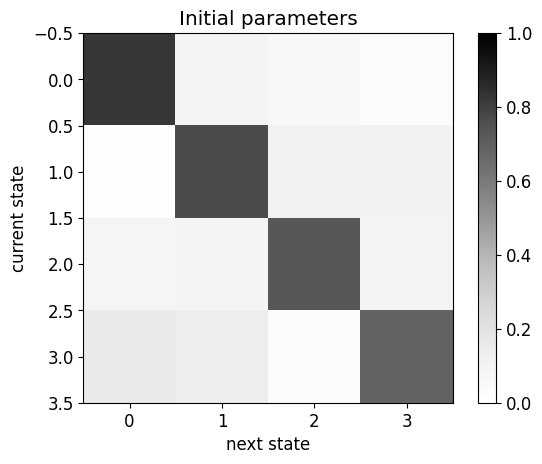

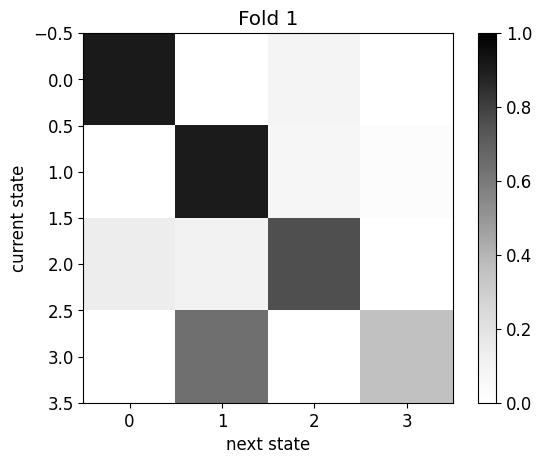

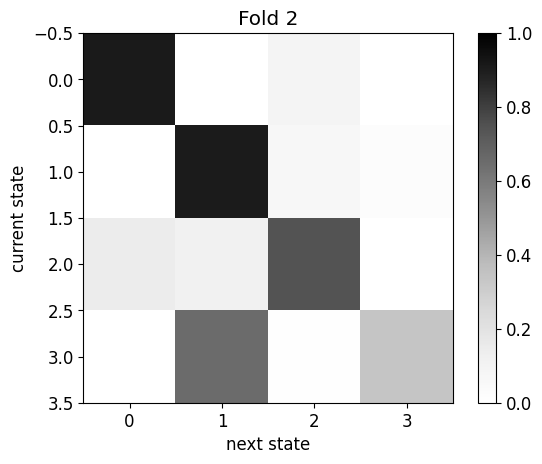

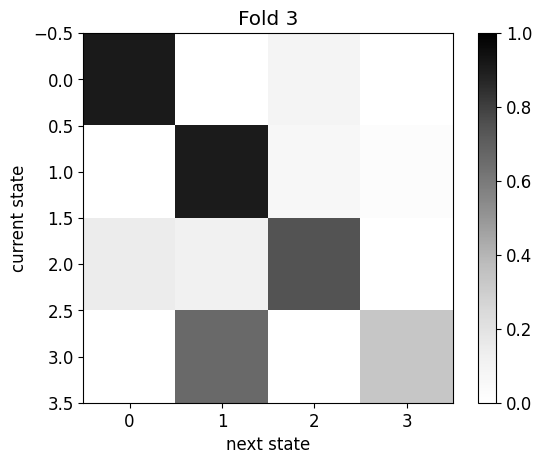

Array([[9.0734458e-01, 7.1028230e-04, 9.1937467e-02, 7.7039131e-06],
       [7.6419001e-06, 9.0575910e-01, 6.8851024e-02, 2.5382234e-02],
       [1.4591575e-01, 1.1145600e-01, 7.4253851e-01, 8.9726505e-05],
       [1.9322814e-04, 6.6256666e-01, 2.5056661e-03, 3.3473444e-01]],      dtype=float32)

In [157]:
plot_transition_mat (init_params, fit_params)

## Find best fold

Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


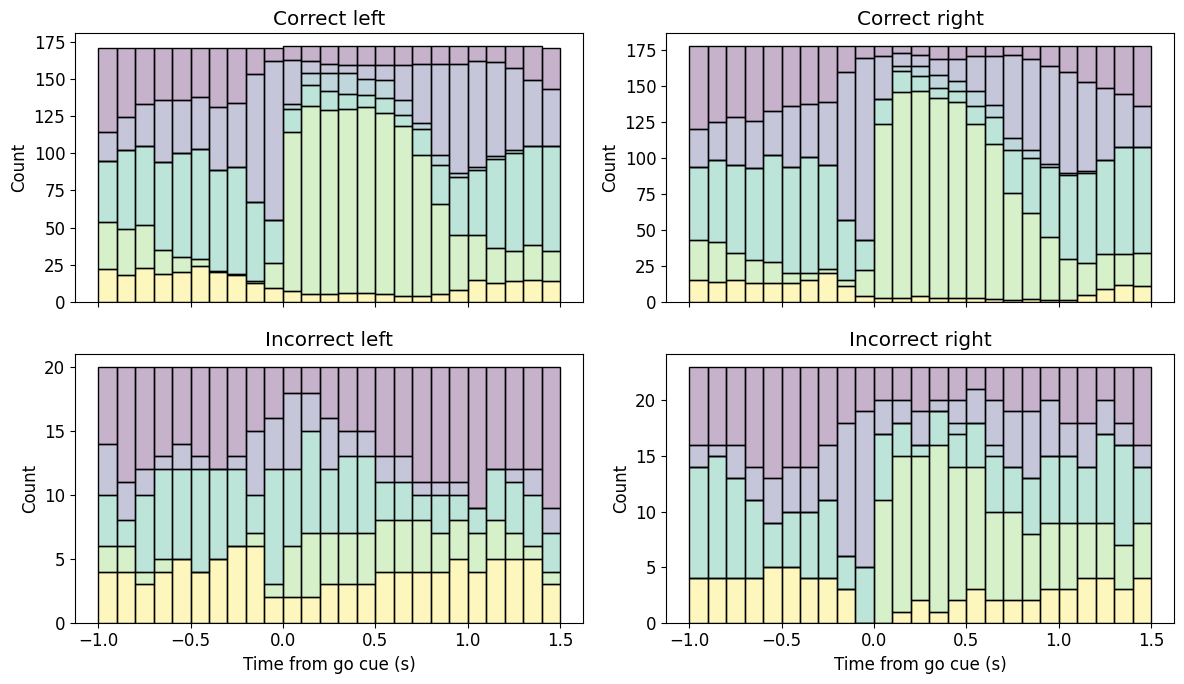

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:394: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:395: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:396: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:397: FutureWarning: Th

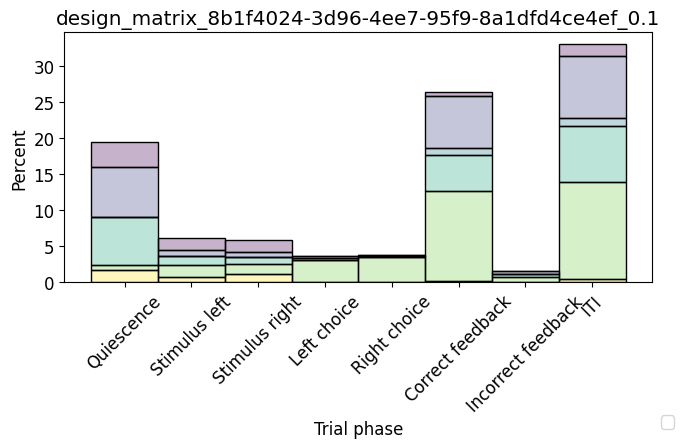

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:412: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2532: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


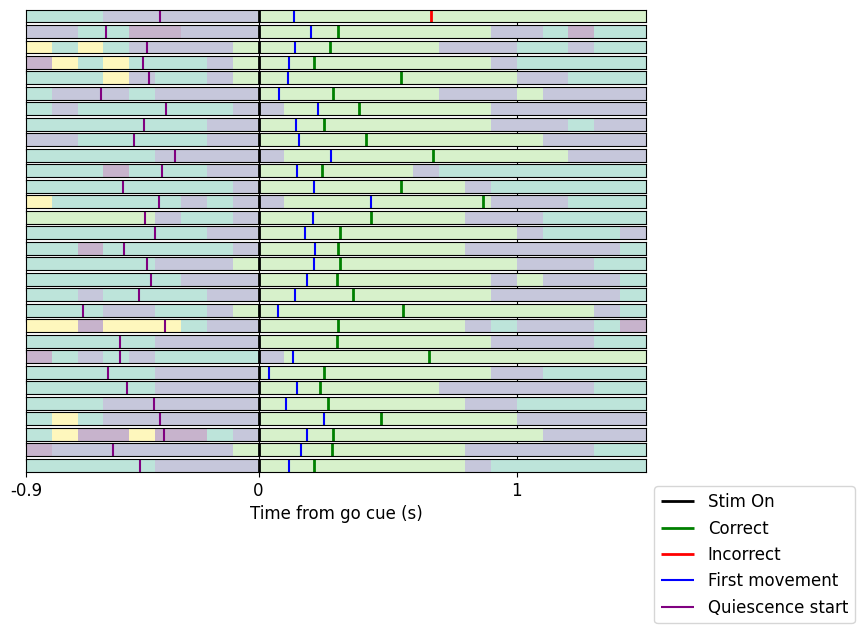

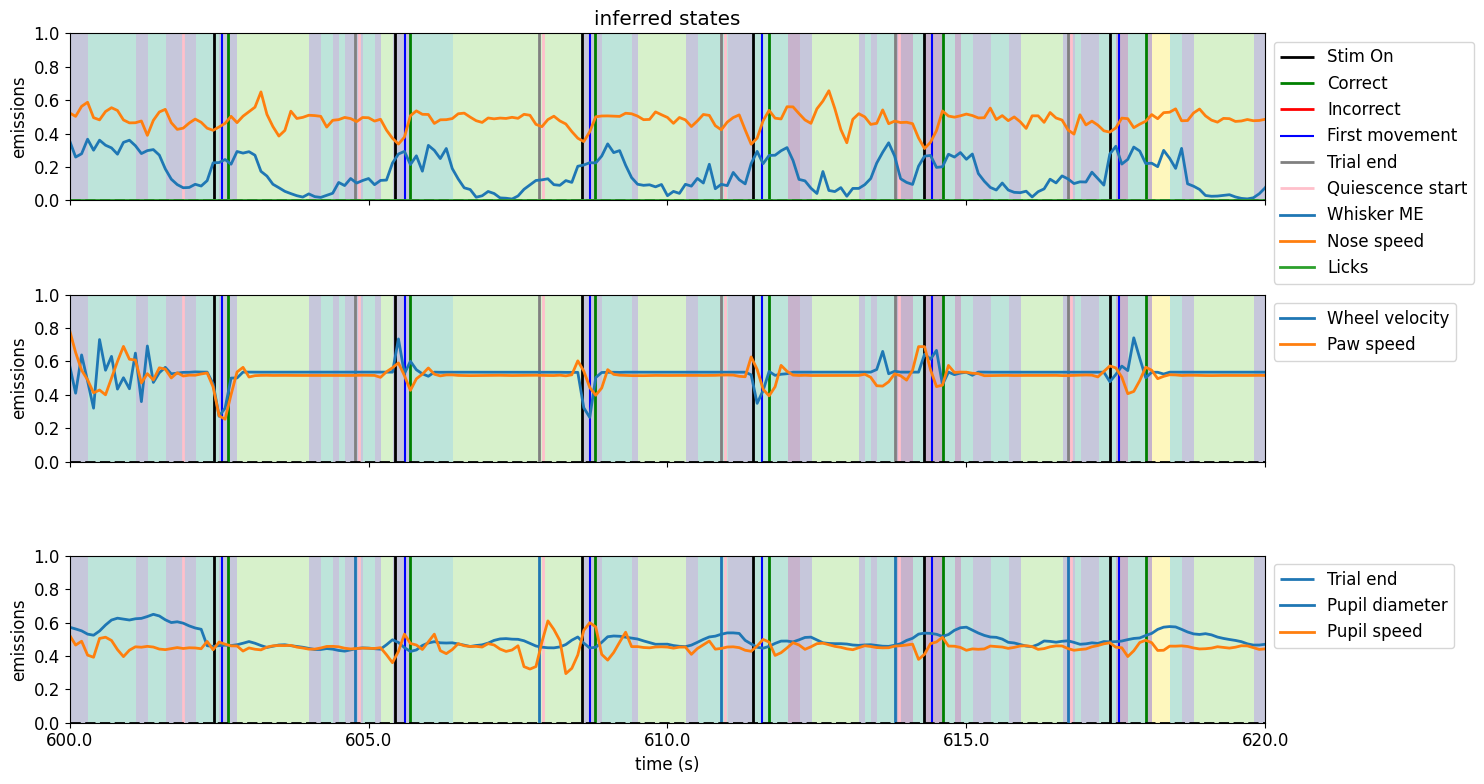

Fitting session 9b5a1754-ac99-4d53-97d3-35c2f6638507


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


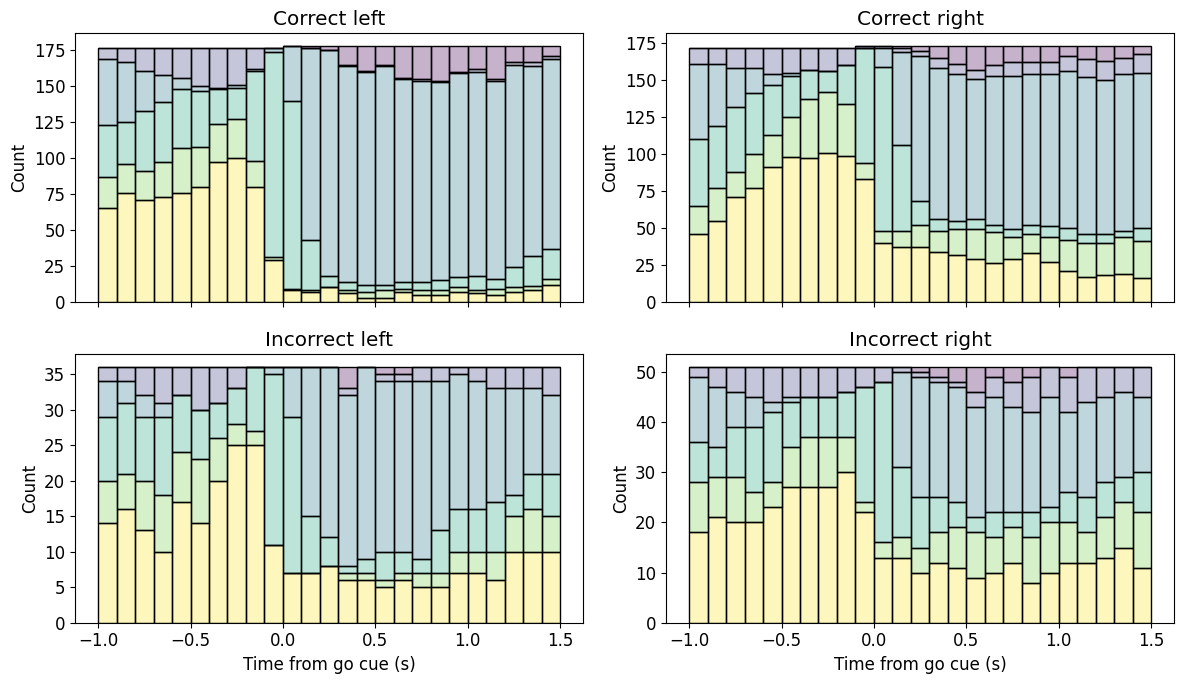

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:394: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:395: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:396: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:397: FutureWarning: Th

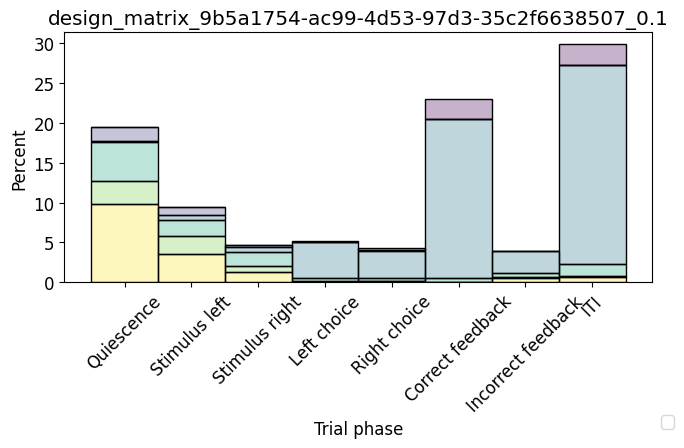

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:412: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


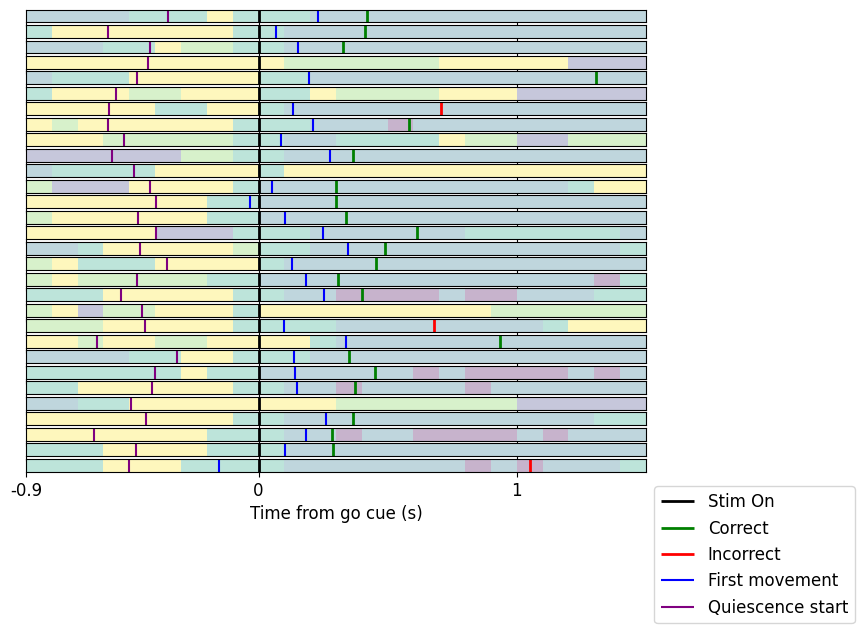

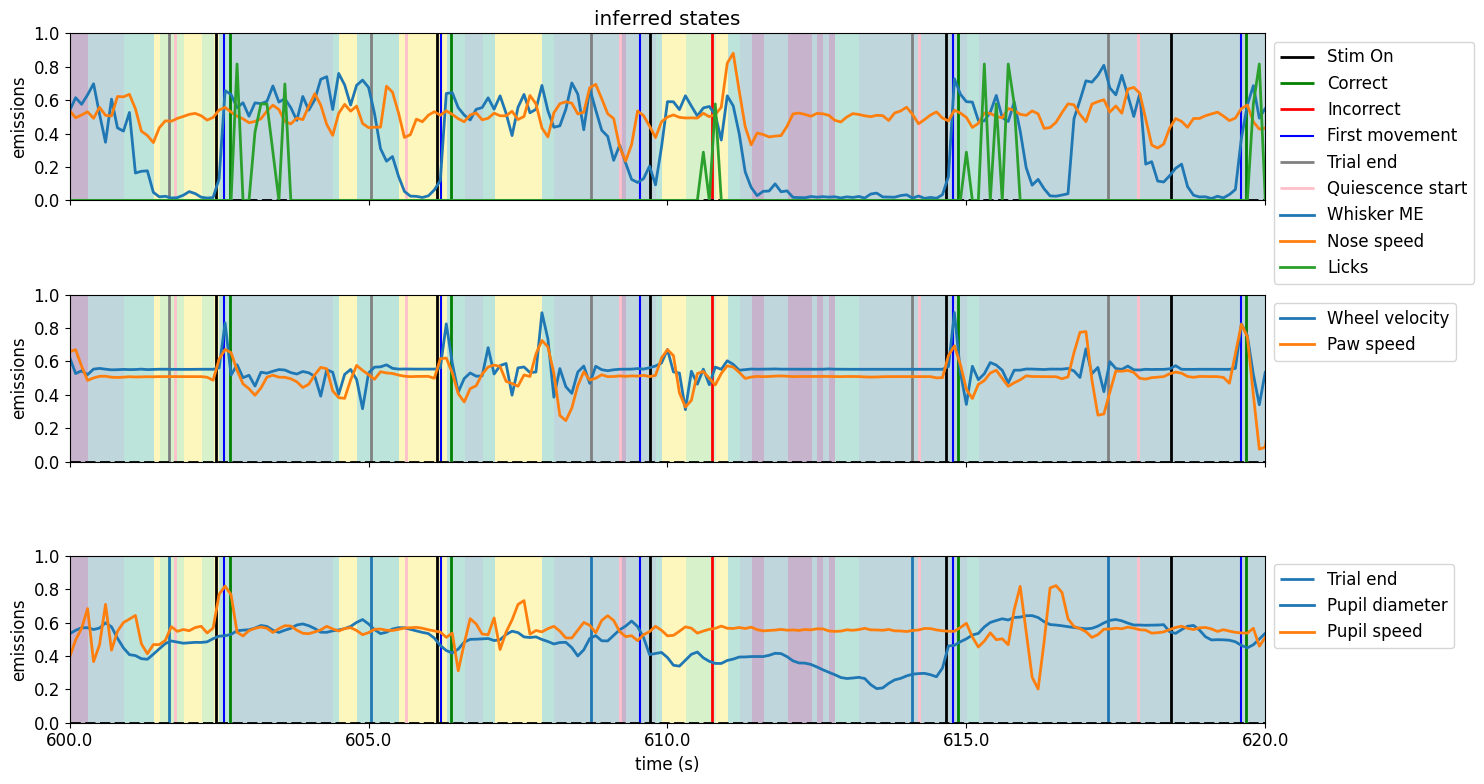

In [18]:
# Fit model for optimal number of states

for s, ses in enumerate(design_matrices[0:2]):
    #ses = 'design_matrix_d23a44ef-1402-4ed7-97f5-47e9a7a504d9_0.1'
    session_trials = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Trials data
    session = design_matrices[s][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(ses, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]
    
    " Fit model "
    # Fit again (TODO: should save these results from the code above)
    num_timesteps = np.shape(matrix_all[ses][0])[0]
    emission_dim = np.shape(matrix_all[ses][0])[1]
    shortened_array = np.array(matrix_all[ses][0][:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
   
    test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    val_lls, fit_params, init_params, baseline_lls, train_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), shortened_array, train_emissions, 'kmeans', num_train_batches)

    " Find best fold (this is what Zoe does) results "
    use_fold = np.where(val_lls==np.max(val_lls))[0][0]
    print(use_fold)
        
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_means = fit_params[2].means[use_fold]
    emission_covs = fit_params[2].covs[use_fold]
        
    # Initialize new hmm
    new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="prior", initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs,
                                    emissions=matrix_all[ses][0])  # not sure if I need to include  

    # Get state estimates for validation data
    most_likely_states = new_hmm.most_likely_states(best_fold_params, matrix_all[ses][0])
    
    """ Plot frequencey of most_likely_states """
    """
    bins = np.arange(0, 100, 1)
    plt.hist(most_likely_states, bins)
    plt.xlabel('State')
    plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
    plt.ylabel('Number of bins')
    plt.title(ses)
    plt.show()
    """
    
    """ Plot states per trial type, aligned on events """
    #test_set = test_all[ses][0]
    init = -10
    end = 15
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix, most_likely_states, multiplier)
                                            
    plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
    
    """ Plot fit parameters """
    #states = ('State 0', "State 1", "State 2", 'State 3') 
    #states = ('State 0', 'State 1', 'State 2')
    states = []
    for s in range(num_states):
        state = 'State ' + str(s)
        states.append(state)
    
    # fig, ax = plt.subplots(ncols=len(states) , nrows=1, sharex=True, sharey=True, figsize=[20, 5])
    # plt.rc('font', size=12)

    # learned_params = params_to_df (var_names, len(states), num_train_batches, fit_params, norm_results=False)
    # for s, state in enumerate(states):
    #     use_data = learned_params.loc[learned_params['state']==s]
    #     sns.barplot(y='variable', x='value', data=use_data, ax=ax[s], palette='plasma')
    #     ax[s].vlines(0, -.50, 9.5, color='Gray', linestyles='--', linewidth=1)
    #     ax[s].set_xlabel('Mean')
    #     #ax[s].set_title(state)

    # plt.tight_layout()
    # plt.title(ses)
    # plt.show()

    """ Plot states per trial phase """
    colors = sns.color_palette("viridis", num_states)
    states_trial = states_per_trial_phase(empirical_data, session_trials)
    plt.figure(figsize=[7, 5])
    sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                        multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
    plt.xlabel('Trial phase')
    plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(ses)
    plt.show()
    

    """ Stack trial states """
    trial_init = 100  # First trial to plot
    trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
    plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)
    

    """ Plot raw traces over states """
    init = 6000  # First bin
    traces_over_sates(init, design_matrix, most_likely_states, session_trials, var_names)
    
    

/tmp/ipykernel_46544/3566805684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


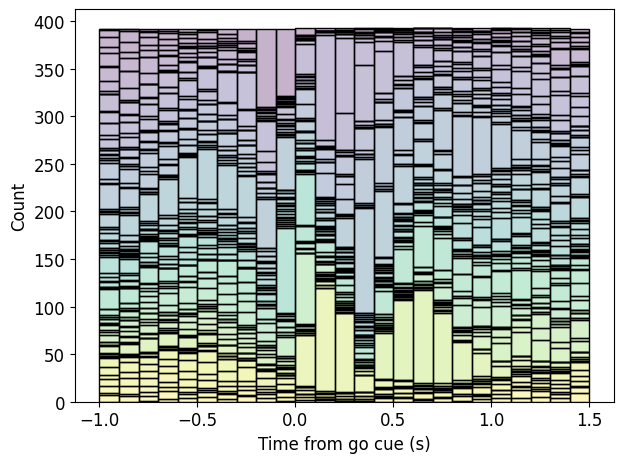

In [10]:
    # PLOT
    plt.rc('font', size=12)
    use_data = empirical_data.dropna()
    use_data['new_bin'] = use_data['new_bin'] * bin_size
    
    sns.histplot(x='new_bin', hue='most_likely_states', data=use_data, stat='count', alpha=0.3, 
                    multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, palette='viridis')

    ax.set_xlabel(str('Time from go cue (s)'))
    plt.xlabel('Time from go cue (s)')

    plt.tight_layout()
    plt.show()

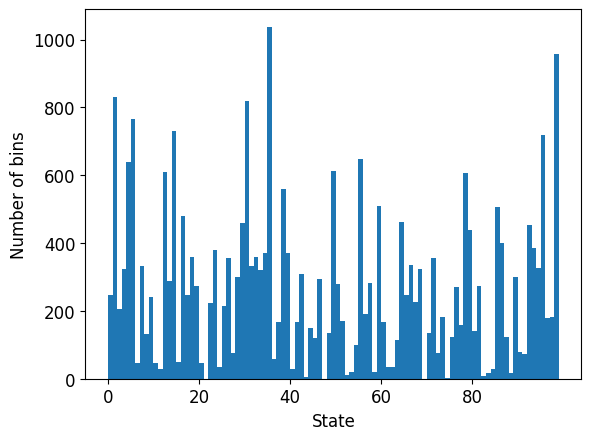

In [14]:
# Plot histogram
bins = np.arange(0, num_states, 1)
plt.hist(most_likely_states, bins)
plt.xlabel('State')
plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
plt.ylabel('Number of bins')
plt.xticks(np.arange(0, 100, 20), np.arange(0, 100, 20))
#plt.title(ses)
plt.show()

### Reduce states to represent

In [8]:
counts, _ = np.histogram(most_likely_states, bins=num_states)

In [9]:
session_length = np.sum(counts)
session_length

threshold_bins = 0.95*session_length  # minimum number of bins that the state appeared in (100 corresponds to 10 seconds on the total session)
threshold = np.ceil(session_length - threshold_bins)

threshold = 150

In [10]:
np.sum(counts>threshold)

60

In [11]:
np.sum(counts[counts>threshold])/np.sum(counts)

0.8882374906646752

In [13]:
_, remove_states = np.where([counts<threshold])

# Create a mask for values in array A that are in array B
mask = np.isin(most_likely_states, remove_states)

# Replace matching values in array A with NaN
new_states = np.array(most_likely_states, dtype=float)
new_states[mask] = np.nan


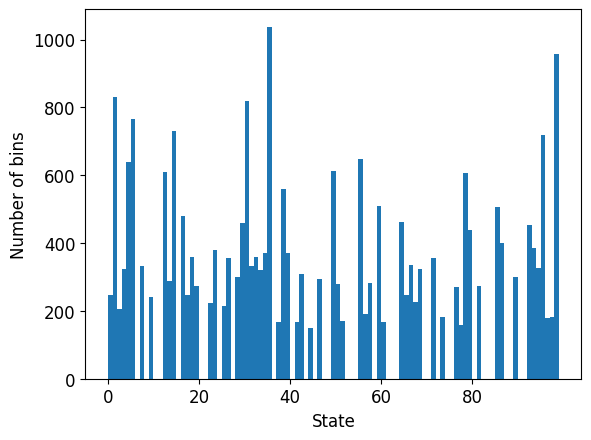

In [22]:
# Plot histogram
bins = np.arange(0, num_states, 1)
plt.hist(new_states, bins)
plt.xlabel('State')
plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
plt.ylabel('Number of bins')
plt.xticks(np.arange(0, 100, 20), np.arange(0, 100, 20))
#plt.title(ses)
plt.show()

## Plot without removed states

In [6]:
# Fit model for optimal number of states

for s, ses in enumerate(design_matrices[0:2]):
    #ses = 'design_matrix_d23a44ef-1402-4ed7-97f5-47e9a7a504d9_0.1'
    session_trials = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Trials data
    session = design_matrices[s][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(ses, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]
    
    " Fit model "
    # Fit again (TODO: should save these results from the code above)
    num_timesteps = np.shape(matrix_all[ses][0])[0]
    emission_dim = np.shape(matrix_all[ses][0])[1]
    shortened_array = np.array(matrix_all[ses][0][:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
   
    test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    val_lls, fit_params, init_params, baseline_lls, train_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), shortened_array, train_emissions, 'kmeans', num_train_batches)

    " Find best fold (this is what Zoe does) results "
    use_fold = np.where(val_lls==np.max(val_lls))[0][0]
    print(use_fold)
        
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_means = fit_params[2].means[use_fold]
    emission_covs = fit_params[2].covs[use_fold]
        
    # Initialize new hmm
    new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="prior", initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs,
                                    emissions=matrix_all[ses][0])  # not sure if I need to include  

    # Get state estimates for validation data
    most_likely_states = new_hmm.most_likely_states(best_fold_params, matrix_all[ses][0])

Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3
Fitting session 9b5a1754-ac99-4d53-97d3-35c2f6638507


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


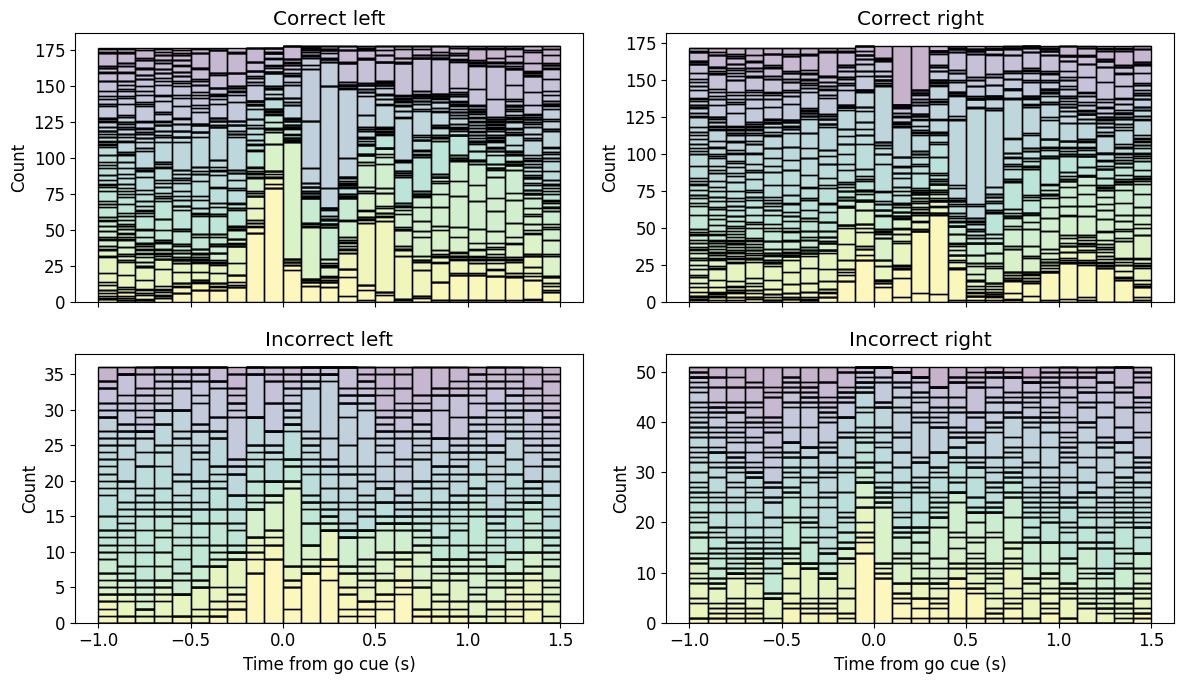

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:394: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:395: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:396: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:397: FutureWarning: Th

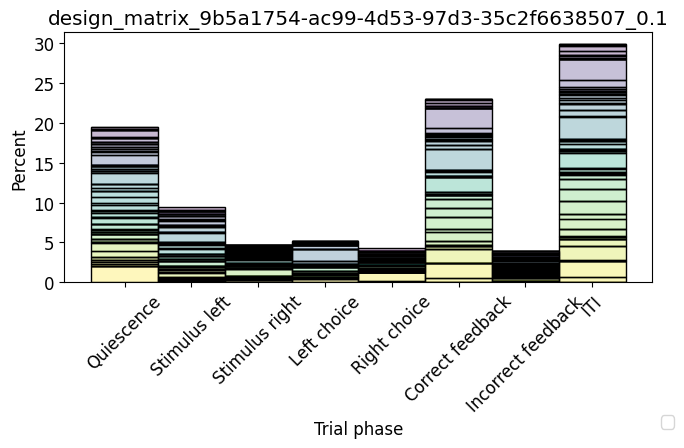

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/fitting_functions.py:412: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


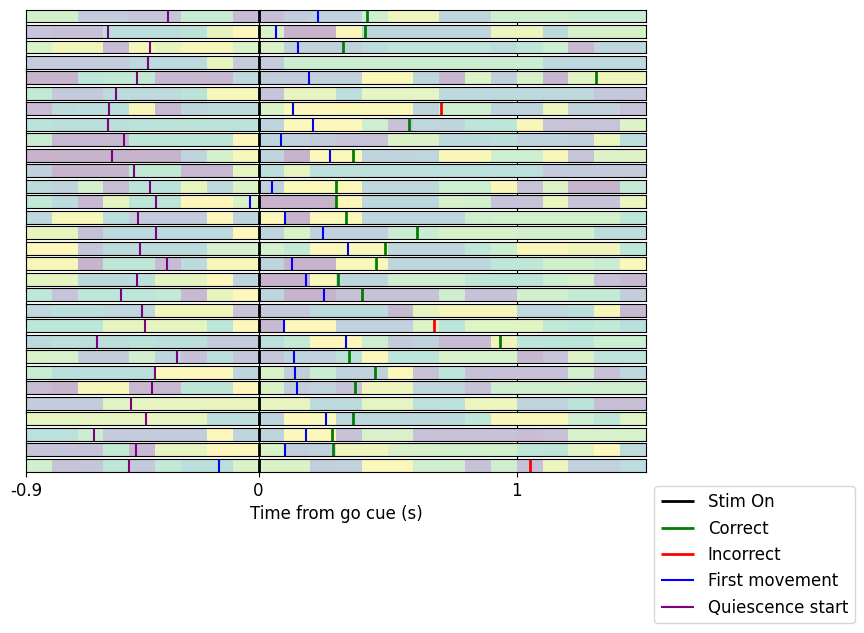

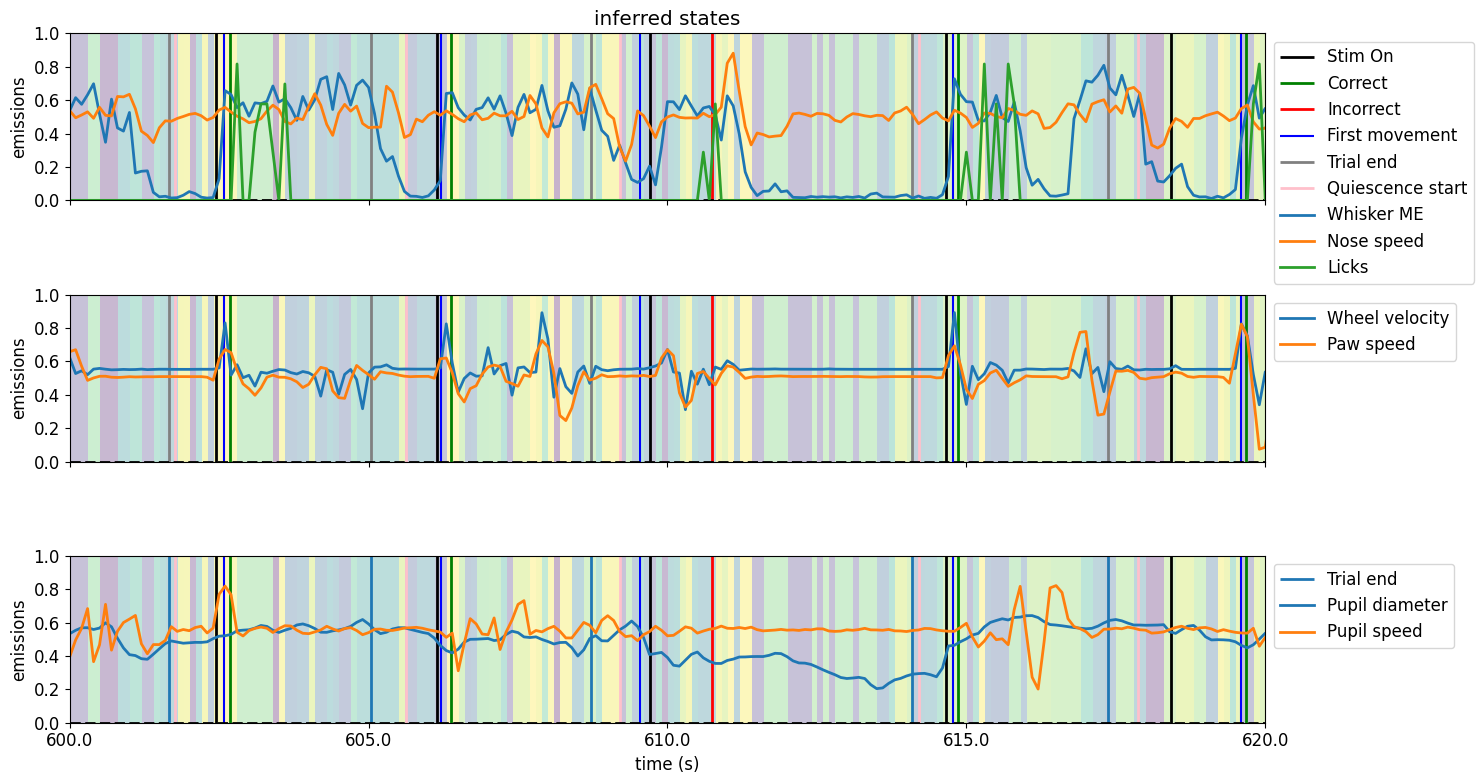

In [15]:
    """ Plot states per trial type, aligned on events """
    #test_set = test_all[ses][0]
    init = -10
    end = 15
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix, most_likely_states, multiplier)
                                            
    plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
    
    """ Plot fit parameters """
    #states = ('State 0', "State 1", "State 2", 'State 3') 
    #states = ('State 0', 'State 1', 'State 2')
    states = []
    for s in range(num_states):
        state = 'State ' + str(s)
        states.append(state)
    
    # fig, ax = plt.subplots(ncols=len(states) , nrows=1, sharex=True, sharey=True, figsize=[20, 5])
    # plt.rc('font', size=12)

    # learned_params = params_to_df (var_names, len(states), num_train_batches, fit_params, norm_results=False)
    # for s, state in enumerate(states):
    #     use_data = learned_params.loc[learned_params['state']==s]
    #     sns.barplot(y='variable', x='value', data=use_data, ax=ax[s], palette='plasma')
    #     ax[s].vlines(0, -.50, 9.5, color='Gray', linestyles='--', linewidth=1)
    #     ax[s].set_xlabel('Mean')
    #     #ax[s].set_title(state)

    # plt.tight_layout()
    # plt.title(ses)
    # plt.show()

    """ Plot states per trial phase """
    colors = sns.color_palette("viridis", num_states)
    states_trial = states_per_trial_phase(empirical_data, session_trials)
    plt.figure(figsize=[7, 5])
    sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                        multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
    plt.xlabel('Trial phase')
    plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(ses)
    plt.show()
    

    """ Stack trial states """
    trial_init = 100  # First trial to plot
    trials_to_plot = 30  # How many trials to plot (if very different will compromise readibility)
    plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)
    

    """ Plot raw traces over states """
    init = 6000  # First bin
    traces_over_sates(init, design_matrix, most_likely_states, session_trials, var_names)

/tmp/ipykernel_46544/3566805684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


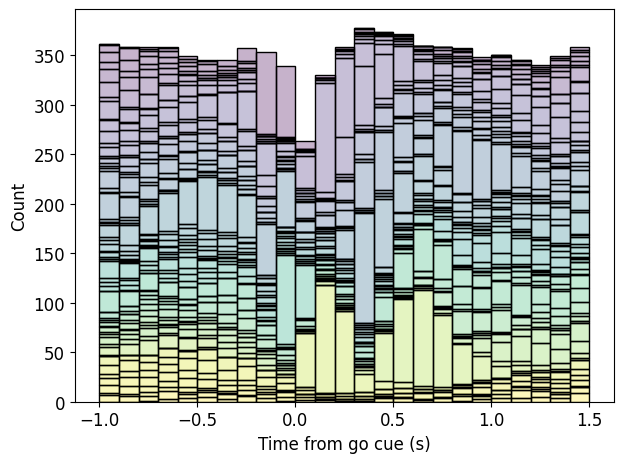

In [24]:
    # PLOT
    plt.rc('font', size=12)
    use_data = empirical_data.dropna()
    use_data['new_bin'] = use_data['new_bin'] * bin_size
    
    sns.histplot(x='new_bin', hue='most_likely_states', data=use_data, stat='count', alpha=0.3, 
                    multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, palette='viridis')

    ax.set_xlabel(str('Time from go cue (s)'))
    plt.xlabel('Time from go cue (s)')

    plt.tight_layout()
    plt.show()